In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2980418296827789425
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7948383028
locality {
  bus_id: 1
}
incarnation: 15056836743982086822
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [6]:
"""
Build RBG Graph
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'

#FLAGS = tf.flags.FLAGS

#tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
#tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)
#eval_type = FLAGS.eval_type
#imagenet_pretrained = FLAGS.imagenet_pretrained
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
rgb_input = tf.placeholder(tf.float32, shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 3))
with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(_NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
model_logits = rgb_logits
model_predictions = tf.nn.softmax(model_logits)


In [7]:
"""
Run sample prediction with RBG only
"""
eval_type = 'rgb'
imagenet_pretrained = True
print("wiener")
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                print("pretrained")
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

wiener
pretrained
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)


ValueError: Cannot feed value of shape (1, 79, 224, 224, 3) for Tensor u'Placeholder:0', which has shape '(1, 25, 224, 224, 3)'

In [10]:
def create_class_visualization(sess, target_y, logits, rgb_input, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    X = 255 * np.random.rand(25, 224, 224, 3)
    X = X[None]
    #X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    # logits command
    # loss = model.classifier[0, target_y] # scalar loss
    loss = logits[0, target_y] # scalar loss
    
    # model.image is just input data 
    # self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
    # grad = tf.gradients(loss, model.image) # gradient of loss with respect to model.image, same size as model.image
    # grad = tf.squeeze(grad) - l2_reg*2*model.image
    
    grad = tf.gradients(loss, rgb_input)
    grad = tf.squeeze(grad) - l2_reg*2*rgb_input
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # we want logits for loss, model.classifier are just logits
        # loss = model.classifier[0, target_y] # scalar loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        # gradient_step = sess.run(grad, feed_dict={model.image:X})
        gradient_step = sess.run(grad, feed_dict={rgb_input:X})
        X += learning_rate * gradient_step
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        #if t % blur_every == 0:
            #X = blur_image(X, sigma=0.5)
        print("iteration:", t, time.time()-start_time)
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            #plt.imshow(deprocess_image(X[0]))
            plt.imshow(X[0][0])
            
            #class_name = class_names[target_y]
            
            class_name = "temp"
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, 25, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
iteration: 0 0.383104085922


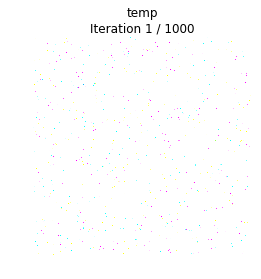

iteration: 1 0.640109062195
iteration: 2 0.842390060425
iteration: 3 1.06433701515
iteration: 4 1.26750397682
iteration: 5 1.46361303329
iteration: 6 1.66530895233
iteration: 7 1.86985588074
iteration: 8 2.0742380619
iteration: 9 2.27747988701
iteration: 10 2.48103189468
iteration: 11 2.69894790649
iteration: 12 2.97474694252
iteration: 13 3.25519990921
iteration: 14 3.53853201866
iteration: 15 3.81826710701
iteration: 16 4.09584403038
iteration: 17 4.3736410141
iteration: 18 4.64145994186
iteration: 19 4.85569906235
iteration: 20 5.06856107712
iteration: 21 5.27175688744
iteration: 22 5.47651004791
iteration: 23 5.67540502548
iteration: 24 5.87722396851


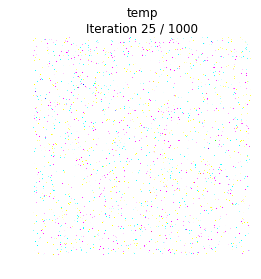

iteration: 25 6.14667487144
iteration: 26 6.37136387825
iteration: 27 6.58049488068
iteration: 28 6.79030299187
iteration: 29 7.01074695587
iteration: 30 7.25189995766
iteration: 31 7.50721406937
iteration: 32 7.77439308167
iteration: 33 8.049877882
iteration: 34 8.32663607597
iteration: 35 8.6023850441
iteration: 36 8.87447309494
iteration: 37 9.14495801926
iteration: 38 9.42814493179
iteration: 39 9.70065188408
iteration: 40 9.97948789597
iteration: 41 10.2509920597
iteration: 42 10.5278499126
iteration: 43 10.8021700382
iteration: 44 11.0771560669
iteration: 45 11.3470380306
iteration: 46 11.6306300163
iteration: 47 11.9082200527
iteration: 48 12.1850030422
iteration: 49 12.4440550804


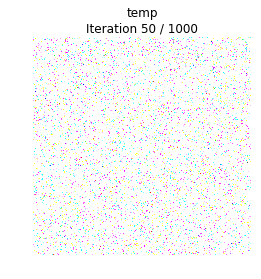

iteration: 50 12.7205550671
iteration: 51 12.9324328899
iteration: 52 13.1754078865
iteration: 53 13.4352359772
iteration: 54 13.7075719833
iteration: 55 13.967040062
iteration: 56 14.181704998
iteration: 57 14.4194290638
iteration: 58 14.6736469269
iteration: 59 14.9261291027
iteration: 60 15.139936924
iteration: 61 15.36865592
iteration: 62 15.6108078957
iteration: 63 15.8255939484
iteration: 64 16.066382885
iteration: 65 16.2813119888
iteration: 66 16.5207939148
iteration: 67 16.7762079239
iteration: 68 17.0468010902
iteration: 69 17.3173160553
iteration: 70 17.5934400558
iteration: 71 17.8343598843
iteration: 72 18.0455908775
iteration: 73 18.2618730068
iteration: 74 18.4776799679


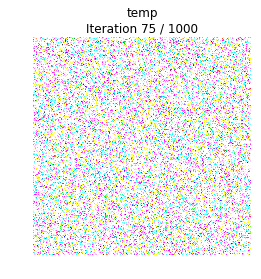

iteration: 75 18.8098599911
iteration: 76 19.0517370701
iteration: 77 19.3096458912
iteration: 78 19.5745339394
iteration: 79 19.8297650814
iteration: 80 20.0468029976
iteration: 81 20.2860589027
iteration: 82 20.5034999847
iteration: 83 20.7132461071
iteration: 84 20.9254689217
iteration: 85 21.137139082
iteration: 86 21.3528969288
iteration: 87 21.5780730247
iteration: 88 21.7924439907
iteration: 89 22.0038430691
iteration: 90 22.2163619995
iteration: 91 22.4281070232
iteration: 92 22.6513910294
iteration: 93 22.8978390694
iteration: 94 23.1481349468
iteration: 95 23.4137759209
iteration: 96 23.670468092
iteration: 97 23.8818368912
iteration: 98 24.0949809551
iteration: 99 24.3073999882


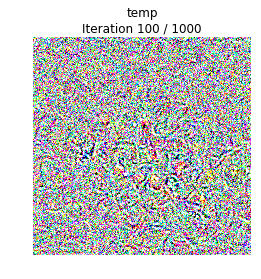

iteration: 100 24.6332690716
iteration: 101 24.8738350868
iteration: 102 25.1124899387
iteration: 103 25.3656420708
iteration: 104 25.6311171055
iteration: 105 25.906359911
iteration: 106 26.1780240536
iteration: 107 26.4522960186
iteration: 108 26.7311110497
iteration: 109 26.9915800095
iteration: 110 27.2140140533
iteration: 111 27.4555549622
iteration: 112 27.6697530746
iteration: 113 27.884278059
iteration: 114 28.0999720097
iteration: 115 28.3184440136
iteration: 116 28.5312199593
iteration: 117 28.7436180115
iteration: 118 28.9579629898
iteration: 119 29.1727020741
iteration: 120 29.4116919041
iteration: 121 29.622852087
iteration: 122 29.836824894
iteration: 123 30.0532000065
iteration: 124 30.2936549187


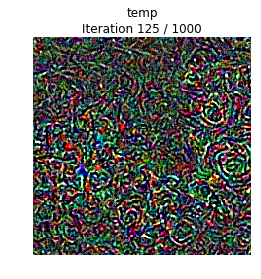

iteration: 125 30.5989060402
iteration: 126 30.8172380924
iteration: 127 31.043941021
iteration: 128 31.2578070164
iteration: 129 31.4719030857
iteration: 130 31.6912710667
iteration: 131 31.906400919
iteration: 132 32.1202809811
iteration: 133 32.3372659683
iteration: 134 32.5733070374
iteration: 135 32.8101050854
iteration: 136 33.04946208
iteration: 137 33.2972810268
iteration: 138 33.514539957
iteration: 139 33.7302920818
iteration: 140 33.9571940899
iteration: 141 34.1971271038
iteration: 142 34.4115309715
iteration: 143 34.625109911
iteration: 144 34.8414459229
iteration: 145 35.0598371029
iteration: 146 35.3008229733
iteration: 147 35.515335083
iteration: 148 35.7298190594
iteration: 149 35.9446809292


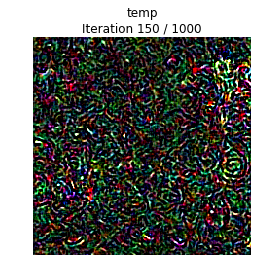

iteration: 150 36.2652730942
iteration: 151 36.4800469875
iteration: 152 36.7147669792
iteration: 153 36.9693260193
iteration: 154 37.189522028
iteration: 155 37.4266729355
iteration: 156 37.6455519199
iteration: 157 37.8786640167
iteration: 158 38.0995049477
iteration: 159 38.347892046
iteration: 160 38.5976760387
iteration: 161 38.8199820518
iteration: 162 39.0594739914
iteration: 163 39.2744109631
iteration: 164 39.5191979408
iteration: 165 39.7741210461
iteration: 166 40.0425179005
iteration: 167 40.3149120808
iteration: 168 40.5867769718
iteration: 169 40.8011510372
iteration: 170 41.0177800655
iteration: 171 41.2312679291
iteration: 172 41.4482140541
iteration: 173 41.6673278809
iteration: 174 41.9062130451


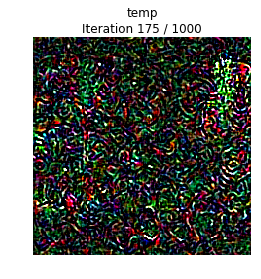

iteration: 175 42.2614860535
iteration: 176 42.5120489597
iteration: 177 42.7763810158
iteration: 178 43.0462329388
iteration: 179 43.3218939304
iteration: 180 43.6037828922
iteration: 181 43.8724780083
iteration: 182 44.1410119534
iteration: 183 44.3934140205
iteration: 184 44.6471090317
iteration: 185 44.8979840279
iteration: 186 45.1198260784
iteration: 187 45.3369259834
iteration: 188 45.5572509766
iteration: 189 45.7936658859
iteration: 190 46.0346560478
iteration: 191 46.2541379929
iteration: 192 46.5050370693
iteration: 193 46.7653930187
iteration: 194 47.0311739445
iteration: 195 47.2663118839
iteration: 196 47.4856119156
iteration: 197 47.7020750046
iteration: 198 47.9227170944
iteration: 199 48.1654689312


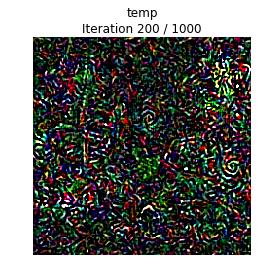

iteration: 200 48.4768569469
iteration: 201 48.694259882
iteration: 202 48.9166750908
iteration: 203 49.146173954
iteration: 204 49.3682460785
iteration: 205 49.5886690617
iteration: 206 49.8065590858
iteration: 207 50.0236599445
iteration: 208 50.2432620525
iteration: 209 50.463342905
iteration: 210 50.6845300198
iteration: 211 50.9025490284
iteration: 212 51.1228439808
iteration: 213 51.3514559269
iteration: 214 51.5717420578
iteration: 215 51.7957959175
iteration: 216 52.0217170715
iteration: 217 52.2421429157
iteration: 218 52.495016098
iteration: 219 52.7579939365
iteration: 220 53.0197410583
iteration: 221 53.2428410053
iteration: 222 53.4874110222
iteration: 223 53.7060608864
iteration: 224 53.9304349422


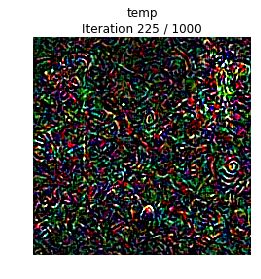

iteration: 225 54.2421340942
iteration: 226 54.4622280598
iteration: 227 54.6876370907
iteration: 228 55.0759608746
iteration: 229 55.3277900219
iteration: 230 55.5911309719
iteration: 231 55.8522200584
iteration: 232 56.1131269932
iteration: 233 56.3857629299
iteration: 234 56.6634979248
iteration: 235 56.9464170933
iteration: 236 57.1693239212
iteration: 237 57.4018850327
iteration: 238 57.6882219315
iteration: 239 57.9295721054
iteration: 240 58.2173929214
iteration: 241 58.5058469772
iteration: 242 58.7899301052
iteration: 243 59.0755848885
iteration: 244 59.3618838787
iteration: 245 59.6532468796
iteration: 246 59.935008049
iteration: 247 60.2011730671
iteration: 248 60.4833090305
iteration: 249 60.7134509087


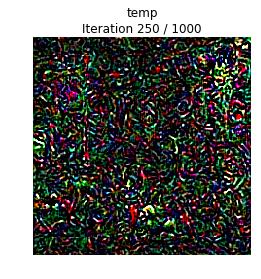

iteration: 250 61.0704269409
iteration: 251 61.3224480152
iteration: 252 61.5854458809
iteration: 253 61.8113288879
iteration: 254 62.0631980896
iteration: 255 62.3241019249
iteration: 256 62.5970239639
iteration: 257 62.8708109856
iteration: 258 63.0985279083
iteration: 259 63.349588871
iteration: 260 63.6081359386
iteration: 261 63.8316159248
iteration: 262 64.0616810322
iteration: 263 64.3174860477
iteration: 264 64.581414938
iteration: 265 64.850894928
iteration: 266 65.1248569489
iteration: 267 65.3939490318
iteration: 268 65.665186882
iteration: 269 65.9426159859
iteration: 270 66.2210569382
iteration: 271 66.4926550388
iteration: 272 66.7199370861
iteration: 273 66.9623069763
iteration: 274 67.1902558804


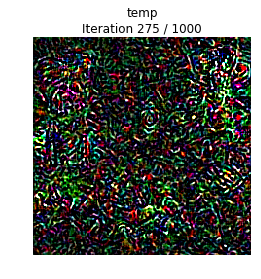

iteration: 275 67.5127770901
iteration: 276 67.7679789066
iteration: 277 68.0319099426
iteration: 278 68.2968258858
iteration: 279 68.5210030079
iteration: 280 68.7486488819
iteration: 281 69.0043139458
iteration: 282 69.2631180286
iteration: 283 69.4961130619
iteration: 284 69.7470810413
iteration: 285 70.0065500736
iteration: 286 70.2476129532
iteration: 287 70.471462965
iteration: 288 70.687556982
iteration: 289 70.9009780884
iteration: 290 71.1151189804
iteration: 291 71.3272380829
iteration: 292 71.5471520424
iteration: 293 71.7691349983
iteration: 294 71.9867620468
iteration: 295 72.2373991013
iteration: 296 72.5264890194
iteration: 297 72.8094110489
iteration: 298 73.0883100033
iteration: 299 73.3750600815


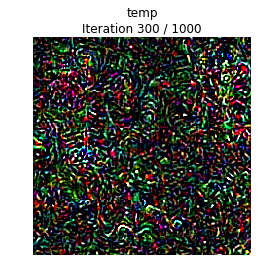

iteration: 300 73.8528690338
iteration: 301 74.1461200714
iteration: 302 74.4341349602
iteration: 303 74.7172570229
iteration: 304 75.0095329285
iteration: 305 75.2950329781
iteration: 306 75.5926170349
iteration: 307 75.8784730434
iteration: 308 76.1725800037
iteration: 309 76.43481493
iteration: 310 76.705794096
iteration: 311 76.9782319069
iteration: 312 77.2559781075
iteration: 313 77.5361120701
iteration: 314 77.8214941025
iteration: 315 78.1163079739
iteration: 316 78.4133760929
iteration: 317 78.6975018978
iteration: 318 78.9316039085
iteration: 319 79.2333810329
iteration: 320 79.5295820236
iteration: 321 79.8249518871
iteration: 322 80.1172549725
iteration: 323 80.3530828953
iteration: 324 80.6090819836


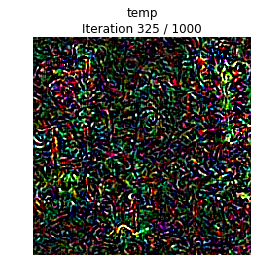

iteration: 325 81.0065340996
iteration: 326 81.259816885
iteration: 327 81.487142086
iteration: 328 81.717869997
iteration: 329 81.9723410606
iteration: 330 82.1996190548
iteration: 331 82.4255030155
iteration: 332 82.6509668827
iteration: 333 82.886772871
iteration: 334 83.1393709183
iteration: 335 83.4017059803
iteration: 336 83.7009608746
iteration: 337 83.9813280106
iteration: 338 84.266616106
iteration: 339 84.5508220196
iteration: 340 84.8600420952
iteration: 341 85.1680169106
iteration: 342 85.4627029896
iteration: 343 85.7654209137
iteration: 344 86.0536968708
iteration: 345 86.3222010136
iteration: 346 86.5492839813
iteration: 347 86.7755529881
iteration: 348 87.0021510124
iteration: 349 87.2397871017


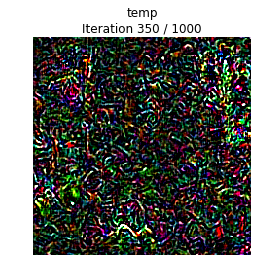

iteration: 350 87.5762701035
iteration: 351 87.8436028957
iteration: 352 88.1271150112
iteration: 353 88.4040930271
iteration: 354 88.6932990551
iteration: 355 88.9786288738
iteration: 356 89.2615540028
iteration: 357 89.5319399834
iteration: 358 89.8080720901
iteration: 359 90.1046199799
iteration: 360 90.4024689198
iteration: 361 90.6989579201
iteration: 362 90.9910230637
iteration: 363 91.2952768803
iteration: 364 91.5811569691
iteration: 365 91.8748559952
iteration: 366 92.1633870602
iteration: 367 92.4473800659
iteration: 368 92.7327148914
iteration: 369 93.0073509216
iteration: 370 93.3007919788
iteration: 371 93.5759088993
iteration: 372 93.8530359268
iteration: 373 94.116975069
iteration: 374 94.3844599724


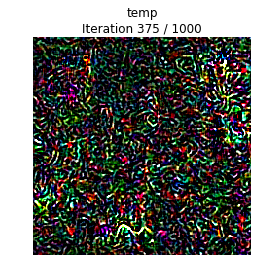

iteration: 375 94.7565579414
iteration: 376 94.9871480465
iteration: 377 95.2445430756
iteration: 378 95.5130369663
iteration: 379 95.7808949947
iteration: 380 96.0472230911
iteration: 381 96.3168280125
iteration: 382 96.549118042
iteration: 383 96.8069190979
iteration: 384 97.0642139912
iteration: 385 97.2931210995
iteration: 386 97.5218679905
iteration: 387 97.7501080036
iteration: 388 97.9819409847
iteration: 389 98.2396841049
iteration: 390 98.5122489929
iteration: 391 98.7823269367
iteration: 392 99.0451540947
iteration: 393 99.2767670155
iteration: 394 99.5344789028
iteration: 395 99.8075969219
iteration: 396 100.102911949
iteration: 397 100.381850958
iteration: 398 100.635948896
iteration: 399 100.872987986


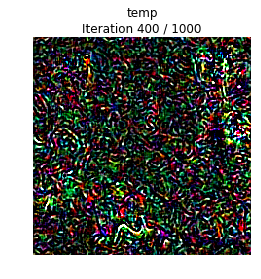

iteration: 400 101.239367008
iteration: 401 101.498578072
iteration: 402 101.768534899
iteration: 403 102.009536028
iteration: 404 102.240521908
iteration: 405 102.479783058
iteration: 406 102.723526001
iteration: 407 102.971968889
iteration: 408 103.205132008
iteration: 409 103.43644309
iteration: 410 103.667661905
iteration: 411 103.909832954
iteration: 412 104.146629095
iteration: 413 104.38259697
iteration: 414 104.616106033
iteration: 415 104.848917007
iteration: 416 105.098062992
iteration: 417 105.348911047
iteration: 418 105.579852104
iteration: 419 105.815254927
iteration: 420 106.04699707
iteration: 421 106.286634922
iteration: 422 106.520843029
iteration: 423 106.779496908
iteration: 424 107.039393902


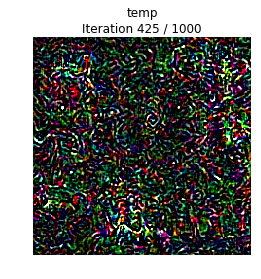

iteration: 425 107.415072918
iteration: 426 107.65053606
iteration: 427 107.915520906
iteration: 428 108.172367096
iteration: 429 108.43699789
iteration: 430 108.711121082
iteration: 431 108.988665104
iteration: 432 109.269412994
iteration: 433 109.545228958
iteration: 434 109.783776045
iteration: 435 110.032880068
iteration: 436 110.294856071
iteration: 437 110.562223911
iteration: 438 110.831057072
iteration: 439 111.063261032
iteration: 440 111.321698904
iteration: 441 111.580835104
iteration: 442 111.812298059
iteration: 443 112.049200058
iteration: 444 112.298610926
iteration: 445 112.556175947
iteration: 446 112.791869879
iteration: 447 113.027255058
iteration: 448 113.283303976
iteration: 449 113.513465881


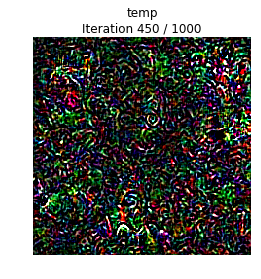

iteration: 450 113.839785099
iteration: 451 114.073009014
iteration: 452 114.309585094
iteration: 453 114.544270039
iteration: 454 114.805152893
iteration: 455 115.053553104
iteration: 456 115.314805984
iteration: 457 115.587025881
iteration: 458 115.865439892
iteration: 459 116.145149946
iteration: 460 116.4327631
iteration: 461 116.710431099
iteration: 462 116.986280918
iteration: 463 117.24465394
iteration: 464 117.481997967
iteration: 465 117.735826015
iteration: 466 117.974268913
iteration: 467 118.235430956
iteration: 468 118.504631042
iteration: 469 118.742418051
iteration: 470 118.979223013
iteration: 471 119.241107941
iteration: 472 119.49040699
iteration: 473 119.751034021
iteration: 474 120.020745993


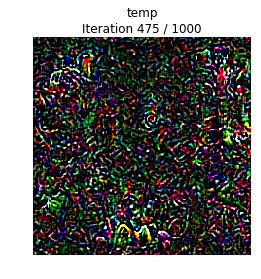

iteration: 475 120.396538019
iteration: 476 120.659213066
iteration: 477 120.931041002
iteration: 478 121.207226992
iteration: 479 121.487432957
iteration: 480 121.765749931
iteration: 481 122.036037922
iteration: 482 122.269397974
iteration: 483 122.499978065
iteration: 484 122.732052088
iteration: 485 122.973169088
iteration: 486 123.240931988
iteration: 487 123.512062073
iteration: 488 123.79487896
iteration: 489 124.086641073
iteration: 490 124.322738886
iteration: 491 124.578156948
iteration: 492 124.810968876
iteration: 493 125.042892933
iteration: 494 125.281950951
iteration: 495 125.514987946
iteration: 496 125.747081995
iteration: 497 125.979336023
iteration: 498 126.208178997
iteration: 499 126.431061983


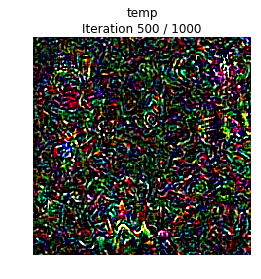

iteration: 500 126.74553895
iteration: 501 126.995606899
iteration: 502 127.261718988
iteration: 503 127.538608074
iteration: 504 127.815371037
iteration: 505 128.086065054
iteration: 506 128.364675999
iteration: 507 128.644747972
iteration: 508 128.918205023
iteration: 509 129.143851995
iteration: 510 129.390106916
iteration: 511 129.63282609
iteration: 512 129.897402048
iteration: 513 130.130451918
iteration: 514 130.364326
iteration: 515 130.598861933
iteration: 516 130.8328619
iteration: 517 131.066138983
iteration: 518 131.297183037
iteration: 519 131.525649071
iteration: 520 131.751075029
iteration: 521 131.980834007
iteration: 522 132.207724094
iteration: 523 132.447053909
iteration: 524 132.670536995


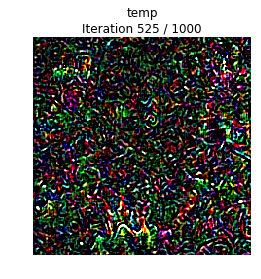

iteration: 525 132.985917091
iteration: 526 133.209480047
iteration: 527 133.43434
iteration: 528 133.661653042
iteration: 529 133.889780998
iteration: 530 134.115243912
iteration: 531 134.343699932
iteration: 532 134.565330029
iteration: 533 134.78699708
iteration: 534 135.013985872
iteration: 535 135.265079975
iteration: 536 135.493649006
iteration: 537 135.723046064
iteration: 538 135.982666969
iteration: 539 136.251003981
iteration: 540 136.530999899
iteration: 541 136.801080942
iteration: 542 137.040709972
iteration: 543 137.300550938
iteration: 544 137.570551872
iteration: 545 137.846394062
iteration: 546 138.125231981
iteration: 547 138.403691053
iteration: 548 138.693248034
iteration: 549 138.975209951


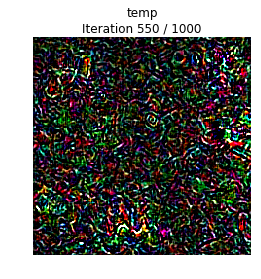

iteration: 550 139.308257103
iteration: 551 139.547621012
iteration: 552 139.811476946
iteration: 553 140.04915905
iteration: 554 140.296683073
iteration: 555 140.562463999
iteration: 556 140.833640099
iteration: 557 141.075723886
iteration: 558 141.328116894
iteration: 559 141.566457987
iteration: 560 141.814328909
iteration: 561 142.050179005
iteration: 562 142.283389091
iteration: 563 142.519440889
iteration: 564 142.756093979
iteration: 565 142.993630886
iteration: 566 143.232373953
iteration: 567 143.45765996
iteration: 568 143.685734987
iteration: 569 143.919555902
iteration: 570 144.167736053
iteration: 571 144.404618025
iteration: 572 144.633840084
iteration: 573 144.862977982
iteration: 574 145.122580051


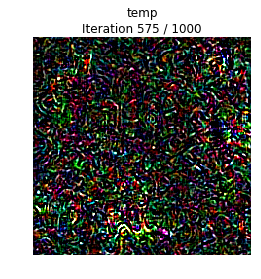

iteration: 575 145.502125978
iteration: 576 145.772197962
iteration: 577 146.045747995
iteration: 578 146.317502022
iteration: 579 146.555242062
iteration: 580 146.792915106
iteration: 581 147.034797907
iteration: 582 147.299695015
iteration: 583 147.574076891
iteration: 584 147.842634916
iteration: 585 148.113002062
iteration: 586 148.386394024
iteration: 587 148.660510063
iteration: 588 148.936274052
iteration: 589 149.178292036
iteration: 590 149.439322948
iteration: 591 149.684751034
iteration: 592 149.946651936
iteration: 593 150.188026905
iteration: 594 150.439810038
iteration: 595 150.676480055
iteration: 596 150.915071011
iteration: 597 151.154100895
iteration: 598 151.392137051
iteration: 599 151.630114079


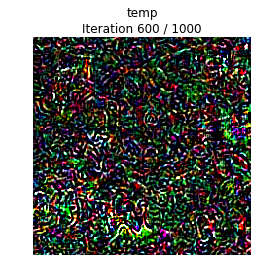

iteration: 600 151.964557886
iteration: 601 152.205677032
iteration: 602 152.466270924
iteration: 603 152.727750063
iteration: 604 152.970187902
iteration: 605 153.237406969
iteration: 606 153.51108408
iteration: 607 153.790591955
iteration: 608 154.056035042
iteration: 609 154.301063061
iteration: 610 154.54064393
iteration: 611 154.784652948
iteration: 612 155.038398027
iteration: 613 155.304883003
iteration: 614 155.578799009
iteration: 615 155.852735996
iteration: 616 156.092189074
iteration: 617 156.331826925
iteration: 618 156.576868057
iteration: 619 156.817790031
iteration: 620 157.056963921
iteration: 621 157.298579931
iteration: 622 157.533525944
iteration: 623 157.763010979
iteration: 624 158.017946959


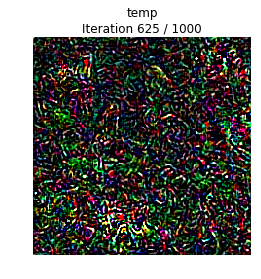

iteration: 625 158.387552023
iteration: 626 158.62904191
iteration: 627 158.878896952
iteration: 628 159.153138876
iteration: 629 159.432411909
iteration: 630 159.711560011
iteration: 631 159.997164011
iteration: 632 160.278313875
iteration: 633 160.558255911
iteration: 634 160.801326036
iteration: 635 161.052352905
iteration: 636 161.323021889
iteration: 637 161.594228029
iteration: 638 161.835386992
iteration: 639 162.080966949
iteration: 640 162.353954077
iteration: 641 162.631481886
iteration: 642 162.910521984
iteration: 643 163.194453955
iteration: 644 163.472040892
iteration: 645 163.712584972
iteration: 646 163.95784688
iteration: 647 164.22744894
iteration: 648 164.481076956
iteration: 649 164.748353958


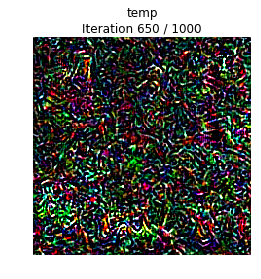

iteration: 650 165.082581997
iteration: 651 165.326901913
iteration: 652 165.575048923
iteration: 653 165.821764946
iteration: 654 166.091329098
iteration: 655 166.371598959
iteration: 656 166.647451878
iteration: 657 166.893605947
iteration: 658 167.16166091
iteration: 659 167.434642076
iteration: 660 167.713937044
iteration: 661 167.976010084
iteration: 662 168.263442039
iteration: 663 168.567357063
iteration: 664 168.846240044
iteration: 665 169.147010088
iteration: 666 169.445499897
iteration: 667 169.76234293
iteration: 668 170.079412937
iteration: 669 170.389003038
iteration: 670 170.738324881
iteration: 671 170.985888958
iteration: 672 171.258703947
iteration: 673 171.536128998
iteration: 674 171.812467098


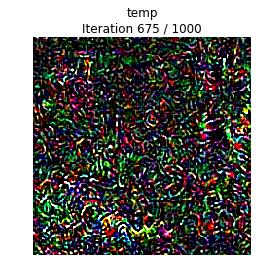

iteration: 675 172.187474012
iteration: 676 172.43264699
iteration: 677 172.698199034
iteration: 678 172.933600903
iteration: 679 173.186487913
iteration: 680 173.459960938
iteration: 681 173.737745047
iteration: 682 174.014405966
iteration: 683 174.25841403
iteration: 684 174.5071311
iteration: 685 174.754154921
iteration: 686 175.028086901
iteration: 687 175.304806948
iteration: 688 175.560559988
iteration: 689 175.881282091
iteration: 690 176.182205915
iteration: 691 176.480830908
iteration: 692 176.742395878
iteration: 693 177.020108938
iteration: 694 177.308973074
iteration: 695 177.622885942
iteration: 696 177.918220997
iteration: 697 178.208230972
iteration: 698 178.49467802
iteration: 699 178.747782946


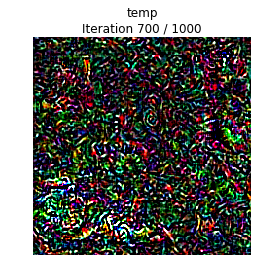

iteration: 700 179.122745991
iteration: 701 179.410782099
iteration: 702 179.692858934
iteration: 703 179.979048967
iteration: 704 180.271694899
iteration: 705 180.562970877
iteration: 706 180.886193991
iteration: 707 181.195321083
iteration: 708 181.48973608
iteration: 709 181.780930996
iteration: 710 182.067374945
iteration: 711 182.349535942
iteration: 712 182.630014896
iteration: 713 182.921799898
iteration: 714 183.210879087
iteration: 715 183.497586012
iteration: 716 183.784178019
iteration: 717 184.061258078
iteration: 718 184.341094017
iteration: 719 184.620285034
iteration: 720 184.906303883
iteration: 721 185.196899891
iteration: 722 185.525074005
iteration: 723 185.833688021
iteration: 724 186.132756948


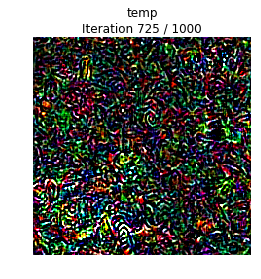

iteration: 725 186.532942057
iteration: 726 186.817774057
iteration: 727 187.099803925
iteration: 728 187.4070611
iteration: 729 187.663197041
iteration: 730 187.952852011
iteration: 731 188.238281012
iteration: 732 188.524256945
iteration: 733 188.819389105
iteration: 734 189.14835906
iteration: 735 189.468204021
iteration: 736 189.73821497
iteration: 737 190.011265039
iteration: 738 190.26637888
iteration: 739 190.553451061
iteration: 740 190.885524988
iteration: 741 191.197709084
iteration: 742 191.493719101
iteration: 743 191.755320072
iteration: 744 192.06672287
iteration: 745 192.378818989
iteration: 746 192.68967104
iteration: 747 192.98636198
iteration: 748 193.26147294
iteration: 749 193.543039083


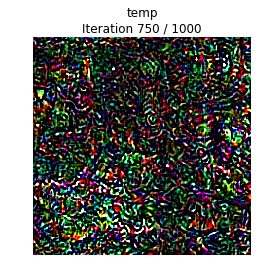

iteration: 750 193.92463088
iteration: 751 194.244618893
iteration: 752 194.551910877
iteration: 753 195.046304941
iteration: 754 195.331157923
iteration: 755 195.616748095
iteration: 756 195.902760029
iteration: 757 196.167056084
iteration: 758 196.453370094
iteration: 759 196.744702101
iteration: 760 197.073186874
iteration: 761 197.372159958
iteration: 762 197.62678504
iteration: 763 197.881319046
iteration: 764 198.136890888
iteration: 765 198.400336027
iteration: 766 198.654105902
iteration: 767 198.913112879
iteration: 768 199.169528008
iteration: 769 199.413426876
iteration: 770 199.659715891
iteration: 771 199.928736925
iteration: 772 200.176021099
iteration: 773 200.425293922
iteration: 774 200.69560504


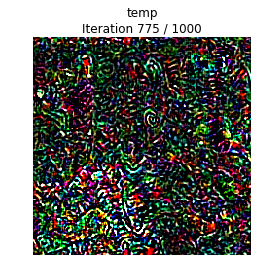

iteration: 775 201.037498951
iteration: 776 201.31803298
iteration: 777 201.577410936
iteration: 778 201.856945992
iteration: 779 202.112595081
iteration: 780 202.371758938
iteration: 781 202.630326986
iteration: 782 202.906862974
iteration: 783 203.185781956
iteration: 784 203.451206923
iteration: 785 203.707803011
iteration: 786 203.966803074
iteration: 787 204.249733925
iteration: 788 204.505260944
iteration: 789 204.764287949
iteration: 790 205.05249095
iteration: 791 205.333267927
iteration: 792 205.593090057
iteration: 793 205.863485098
iteration: 794 206.118928909
iteration: 795 206.382277966
iteration: 796 206.655489922
iteration: 797 206.944431067
iteration: 798 207.231569052
iteration: 799 207.51563096


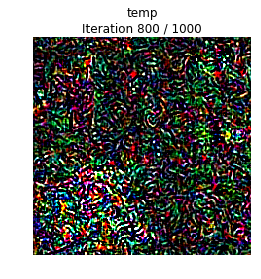

iteration: 800 207.865951061
iteration: 801 208.126324892
iteration: 802 208.394731998
iteration: 803 208.651258945
iteration: 804 208.907797098
iteration: 805 209.165924072
iteration: 806 209.420471907
iteration: 807 209.672782898
iteration: 808 209.919396877
iteration: 809 210.200247049
iteration: 810 210.484375954
iteration: 811 210.766185045
iteration: 812 211.047879934
iteration: 813 211.302646875
iteration: 814 211.556519032
iteration: 815 211.812350035
iteration: 816 212.07220006
iteration: 817 212.359591961
iteration: 818 212.61914587
iteration: 819 212.904145002
iteration: 820 213.160366058
iteration: 821 213.415715933
iteration: 822 213.670800924
iteration: 823 213.93005991
iteration: 824 214.212066889


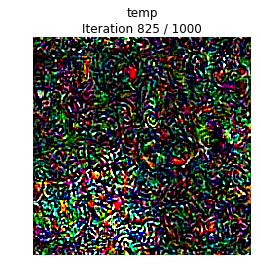

iteration: 825 214.570303917
iteration: 826 214.859293938
iteration: 827 215.140866995
iteration: 828 215.395515919
iteration: 829 215.651643038
iteration: 830 215.906770945
iteration: 831 216.162092924
iteration: 832 216.417672873
iteration: 833 216.669871092
iteration: 834 216.921497107
iteration: 835 217.202080965
iteration: 836 217.486675978
iteration: 837 217.774985075
iteration: 838 218.057936907
iteration: 839 218.317789078
iteration: 840 218.574728012
iteration: 841 218.832272053
iteration: 842 219.097632885
iteration: 843 219.376210928
iteration: 844 219.664638996
iteration: 845 219.952563047
iteration: 846 220.235229969
iteration: 847 220.495418072
iteration: 848 220.771501064
iteration: 849 221.02868104


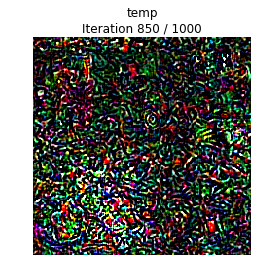

iteration: 850 221.3829
iteration: 851 221.638973951
iteration: 852 221.894809008
iteration: 853 222.152699947
iteration: 854 222.421324015
iteration: 855 222.667017937
iteration: 856 222.91553688
iteration: 857 223.161007881
iteration: 858 223.416419983
iteration: 859 223.686949968
iteration: 860 223.95797801
iteration: 861 224.215342045
iteration: 862 224.471761942
iteration: 863 224.729192972
iteration: 864 224.987974882
iteration: 865 225.260596991
iteration: 866 225.518133879
iteration: 867 225.780394077
iteration: 868 226.056809902
iteration: 869 226.341017962
iteration: 870 226.598651886
iteration: 871 226.861078978
iteration: 872 227.148493052
iteration: 873 227.437970877
iteration: 874 227.726320028


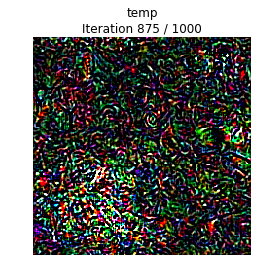

iteration: 875 228.117471933
iteration: 876 228.405133963
iteration: 877 228.694808006
iteration: 878 228.984526873
iteration: 879 229.272459984
iteration: 880 229.560941935
iteration: 881 229.849616051
iteration: 882 230.142814875
iteration: 883 230.430020094
iteration: 884 230.721968889
iteration: 885 231.008954048
iteration: 886 231.300193071
iteration: 887 231.591778994
iteration: 888 231.88115406
iteration: 889 232.169784069
iteration: 890 232.463658094
iteration: 891 232.749379873
iteration: 892 233.009207964
iteration: 893 233.26820302
iteration: 894 233.53008604
iteration: 895 233.789479971
iteration: 896 234.052907944
iteration: 897 234.340471029
iteration: 898 234.60471797
iteration: 899 234.867726088


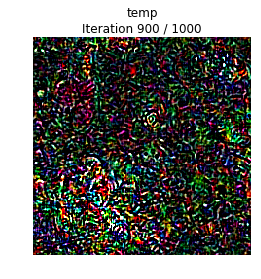

iteration: 900 235.255485058
iteration: 901 235.515609026
iteration: 902 235.773011923
iteration: 903 236.024520874
iteration: 904 236.30152297
iteration: 905 236.581346989
iteration: 906 236.865232944
iteration: 907 237.13036108
iteration: 908 237.421822071
iteration: 909 237.710257053
iteration: 910 237.973151922
iteration: 911 238.265626907
iteration: 912 238.555101871
iteration: 913 238.846426964
iteration: 914 239.142002106
iteration: 915 239.453571081
iteration: 916 239.743846893
iteration: 917 240.035650969
iteration: 918 240.325131893
iteration: 919 240.614865065
iteration: 920 240.900835991
iteration: 921 241.162725925
iteration: 922 241.417376041
iteration: 923 241.673202038
iteration: 924 241.939236879


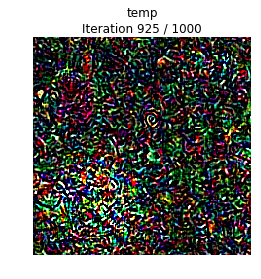

iteration: 925 242.277944088
iteration: 926 242.559159994
iteration: 927 242.847827911
iteration: 928 243.108511925
iteration: 929 243.370377064
iteration: 930 243.635801077
iteration: 931 243.901110888
iteration: 932 244.190177917
iteration: 933 244.484623909
iteration: 934 244.779697895
iteration: 935 245.072035074
iteration: 936 245.363692999
iteration: 937 245.657095909
iteration: 938 245.922451019
iteration: 939 246.185189962
iteration: 940 246.446000099
iteration: 941 246.707937002
iteration: 942 246.973484039
iteration: 943 247.259351015
iteration: 944 247.522965908
iteration: 945 247.795268059
iteration: 946 248.063330889
iteration: 947 248.327303886
iteration: 948 248.59050107
iteration: 949 248.85363698


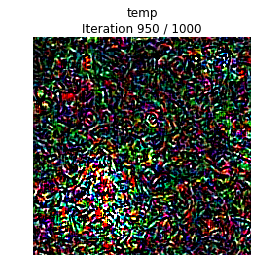

iteration: 950 249.230829954
iteration: 951 249.497688055
iteration: 952 249.762094975
iteration: 953 250.033890963
iteration: 954 250.333278894
iteration: 955 250.623305082
iteration: 956 250.885953903
iteration: 957 251.150520086
iteration: 958 251.425971031
iteration: 959 251.70972991
iteration: 960 252.002418041
iteration: 961 252.296077967
iteration: 962 252.594474077
iteration: 963 252.883275032
iteration: 964 253.144663095
iteration: 965 253.408091068
iteration: 966 253.673270941
iteration: 967 253.940973997
iteration: 968 254.220656872
iteration: 969 254.486177921
iteration: 970 254.75413394
iteration: 971 255.018955946
iteration: 972 255.284904003
iteration: 973 255.541150093
iteration: 974 255.817979097


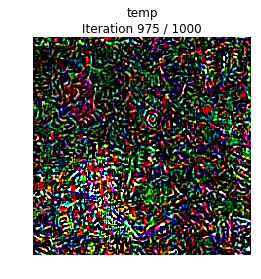

iteration: 975 256.162672997
iteration: 976 256.445719957
iteration: 977 256.7398839
iteration: 978 257.031145096
iteration: 979 257.299885988
iteration: 980 257.590245962
iteration: 981 257.880387068
iteration: 982 258.144865036
iteration: 983 258.409578085
iteration: 984 258.672362089
iteration: 985 258.939167023
iteration: 986 259.221668959
iteration: 987 259.485712051
iteration: 988 259.749320984
iteration: 989 260.014190912
iteration: 990 260.276932001
iteration: 991 260.540352106
iteration: 992 260.830097914
iteration: 993 261.129878044
iteration: 994 261.431788921
iteration: 995 261.727680922
iteration: 996 262.022949934
iteration: 997 262.315917969
iteration: 998 262.580166101
iteration: 999 262.844722986


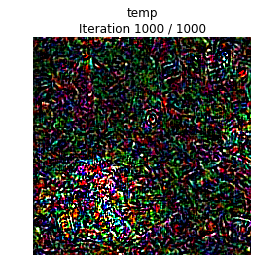

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        create_class_visualization(sess, 6, model_logits, rgb_input, num_iterations=1000)